#### **Gender and Age Classification using CNN**

**Upload the dataset using kaggle**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [32]:
#to access kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [33]:
#download the dataset
!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new -d utkface

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  utkface-new.zip
replace utkface/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**import the libraries**

In [62]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

In [63]:
dataset_path = "/content/utkface/UTKFace"

In [64]:
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# Set path to folder containing .jpg files
dataset_path = "/content/utkface/UTKFace"

images = []
genders = []
ages = []  # Initialize a list for ages

limit = 3000

for i, filename in enumerate(os.listdir(dataset_path)):
    if filename.endswith(".jpg") and i < limit:
        try:
            age, gender = filename.split("_")[0:2]
            age = int(age)
            gender = int(gender)

            img_path = os.path.join(dataset_path, filename)
            img = load_img(img_path, target_size=(128, 128))  # Reduced target size for memory
            img_array = img_to_array(img) / 255.0

            images.append(img_array)
            genders.append(gender)
            ages.append(age)  # Append age to the ages list

        except Exception as e:
            print(f"Skipping {filename}: {e}")

In [65]:
# import os
# print("Exists?", os.path.exists("/content/utkface/UTKFace"))
# print("Files inside:", os.listdir("/content/utkface/UTKFace")[:5])

In [66]:
X = np.array(images)
y = np.array(genders)
y_ages = np.array(ages) # Corrected: Assign y_ages to the ages list
print("Total images loaded :", X.shape[0])
print("Image shape :", X.shape[1:])
print("Gender labels :", np.unique(y, return_counts =True))
print("Age labels :", np.unique(y_ages, return_counts =True))

Total images loaded : 3000
Image shape : (128, 128, 3)
Gender labels : (array([0, 1]), array([1572, 1428]))
Age labels : (array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  92,
        93,  95,  96,  99, 100, 105, 111]), array([148,  67,  38,  30,  25,  12,  23,  32,  16,  17,   8,  10,  10,
        22,  19,  35,  16,  42,  13,  39,  43,  44,  48, 112,  76, 295,
        80, 130,  60,  94,  44,  78,  21,  59, 116,  59,  43,  45,  27,
        65,   9,  40,  17,  13,  51,  21,  27,  18,  14,  46,  24,  30,
        29,  34,  34,  23,  11,  35,  10, 

**visualize the image dataset**

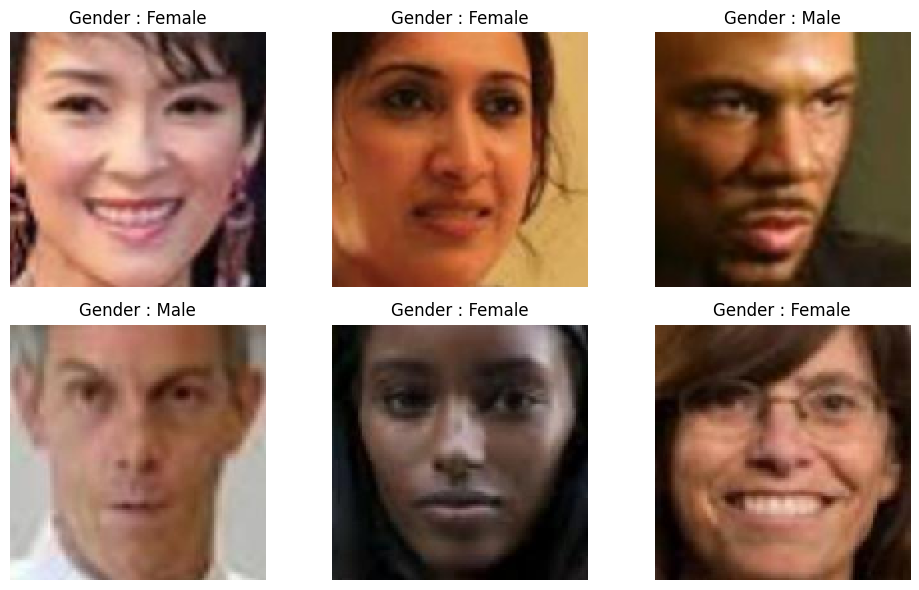

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
for i in range(6):
  plt.subplot(2,3, i+1)
  plt.imshow(X[i])
  plt.title("Gender : " + ("Male" if y[i] == 0 else "Female"))
  plt.axis("off")
plt.tight_layout()
plt.show()

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

print("Training data shape : ", X_train.shape)
print("Testing data shape : ", X_test.shape)

Training data shape :  (2100, 128, 128, 3)
Testing data shape :  (900, 128, 128, 3)


**Build the CNN model**

In [69]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [70]:
#data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.5),
    layers.RandomFlip(),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.Resizing(128, 128) # Resize to match new input shape
])

In [71]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [72]:
def create_model():
  input_tensor = Input(shape=(128, 128, 3)) # Updated input shape

  # Removed data augmentation layer from the model definition
  x = input_tensor

  x = Conv2D(32, (3,3), padding = 'same', activation = 'relu')(x) #convo layer 1
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(64, (3,3), activation = 'relu')(x) #convo layer 2
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(64, (3,3), activation = 'relu')(x) #convo layer 3
  x = BatchNormalization()(x)

  x = Flatten()(x)

  x = Dense(64, activation = 'relu')(x) #ann layer
  x = Dropout(0.5)(x)

  gender_output = Dense(1, activation = 'sigmoid', name = 'gender_output')(x) #since predicting gender label 1 or 0
  age_output = Dense(1, activation='linear', name='age_output')(x)  # Regression

  model = Model(inputs=input_tensor, outputs=[gender_output, age_output])
  return model

In [73]:
modelimgage = create_model()
#model = Model(inputs=input_layer, outputs=[gender_output, age_output])

In [74]:
#compile the model
modelimgage.compile(optimizer = 'adam', loss = {'gender_output' :'binary_crossentropy', 'age_output' : 'mse'}, #mean squared error for regression
                    metrics = {'gender_output' : 'accuracy',
                               'age_output' : 'mae'}) #mean absolute error for age
modelimgage.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 62, 62,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 29, 29,    │     36,928 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 29,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 53824)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │  3,444,800 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │         65 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,501,890 (13.36 MB)

 Trainable params: 3,501,570 (13.36 MB)

 Non-trainable params: 320 (1.25 KB)

In [75]:
early_stopping = callbacks.EarlyStopping(patience = 5, restore_best_weights = True) #Early stopping to stop training if val_loss stops improving

In [76]:
#checking labels
y_gender = np.array(genders)
y_age = np.array(age)
print("Gender labels :", np.unique(y_gender, return_counts =True))
print("Age labels :", np.unique(y_age, return_counts =True))

Gender labels : (array([0, 1]), array([1572, 1428]))
Age labels : (array([34]), array([1]))


In [77]:
#splitting the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_gender, y_test_gender, y_train_age, y_test_age = train_test_split(X, y_gender, y_ages, test_size = 0.2, random_state= 42)

In [78]:
#training the model
# Apply data augmentation to the training data before training
X_train_augmented = data_augmentation(X_train)

history = modelimgage.fit(X_train_augmented, {'gender_output': y_train_gender, 'age_output': y_train_age},
                          validation_data = (X_test, {'gender_output': y_test_gender, 'age_output': y_test_age}),
                          epochs = 20, batch_size = 35,
                          callbacks=[early_stopping]) # Added early stopping callback

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - age_output_loss: 797.6655 - age_output_mae: 22.1010 - gender_output_accuracy: 0.5380 - gender_output_loss: 4.6164 - loss: 802.3645 - val_age_output_loss: 529.8130 - val_age_output_mae: 17.7763 - val_gender_output_accuracy: 0.5300 - val_gender_output_loss: 3.0739 - val_loss: 547.8997
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - age_output_loss: 495.1273 - age_output_mae: 17.3845 - gender_output_accuracy: 0.5261 - gender_output_loss: 6.0617 - loss: 501.1950 - val_age_output_loss: 411.8782 - val_age_output_mae: 15.4874 - val_gender_output_accuracy: 0.5283 - val_gender_output_loss: 5.4002 - val_loss: 421.9807
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - age_output_loss: 429.7526 - age_output_mae: 16.2526 - gender_output_accuracy: 0.5324 - gender_output_loss: 5.1647 - loss: 434.9420 - val_age_output_loss: 899.8148 - val_age_output_mae: 24.3372 - val_gender_output_accuracy: 0.5600 - val_gender_output_loss: 1.8944 - val_loss

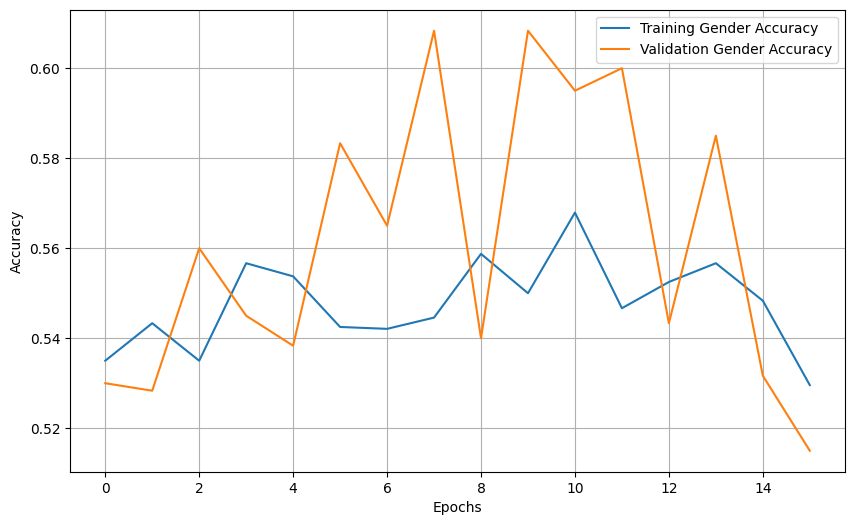

In [86]:
#plot the results
#accuracy plot/result
plt.figure(figsize = (10,6))
plt.plot(history.history['gender_output_accuracy'], label = 'Training Gender Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label = 'Validation Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

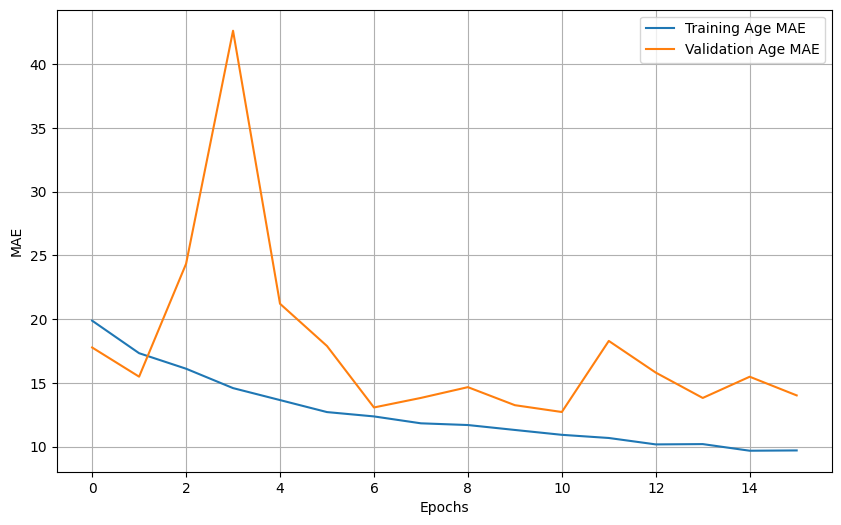

In [85]:
#plot for age mae
plt.figure(figsize = (10,6))
plt.plot(history.history['age_output_mae'], label = 'Training Age MAE')
plt.plot(history.history['val_age_output_mae'], label = 'Validation Age MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

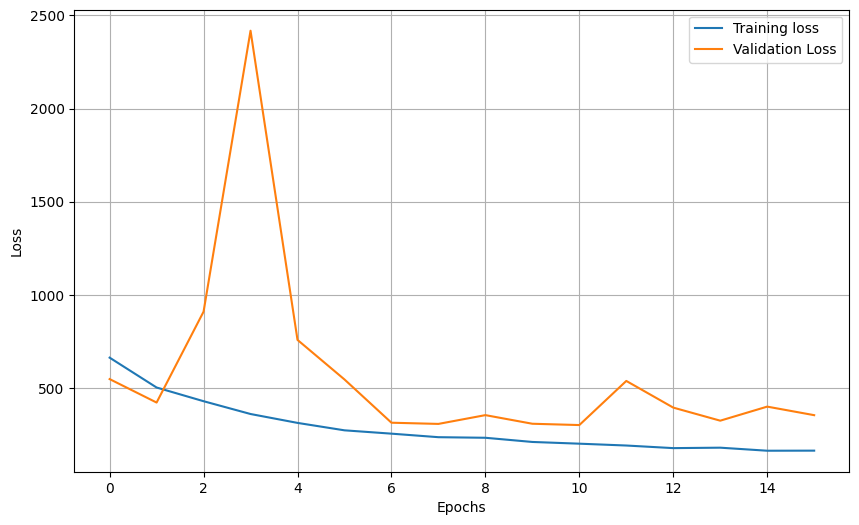

In [82]:
#loss plot/result
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [90]:
#evaluate on test data
test_loss, gender_test_loss, gender_test_accuracy, age_test_loss, age_test_mae = modelimgage.evaluate(X_test, {'gender_output': y_test_gender, 'age_output': y_test_age})
print(f"Test Loss : {test_loss:.4f}")
print(f"Gender Test Loss : {gender_test_loss:.4f}")
print(f"Gender Test Accuracy : {gender_test_accuracy:.4f}")
print(f"Age Test Loss : {age_test_loss:.4f}")
print(f"Age Test MAE : {age_test_mae:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - age_output_loss: 323.7761 - age_output_mae: 13.1828 - gender_output_accuracy: 0.5824 - gender_output_loss: 0.6901 - loss: 324.5208
Test Loss : 301.1659
Gender Test Loss : 0.6773
Gender Test Accuracy : 299.9429
Age Test Loss : 12.7165
Age Test MAE : 0.5950


In [91]:
#saving the model
modelimgage.save('gender_age_model.h5')

In [100]:
# load the model to run prediction
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError

model = load_model("gender_age_model.h5", custom_objects={'mse': MeanSquaredError()})

In [107]:
#predicting the model using test data
gender_predicts, age_predicts = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step


In [108]:
# process predictions
gender_preds = (gender_predicts > 0.5).astype("int")  # binary threshold
age_preds = age_predicts.flatten().astype("int")      # flatten and convert to int

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


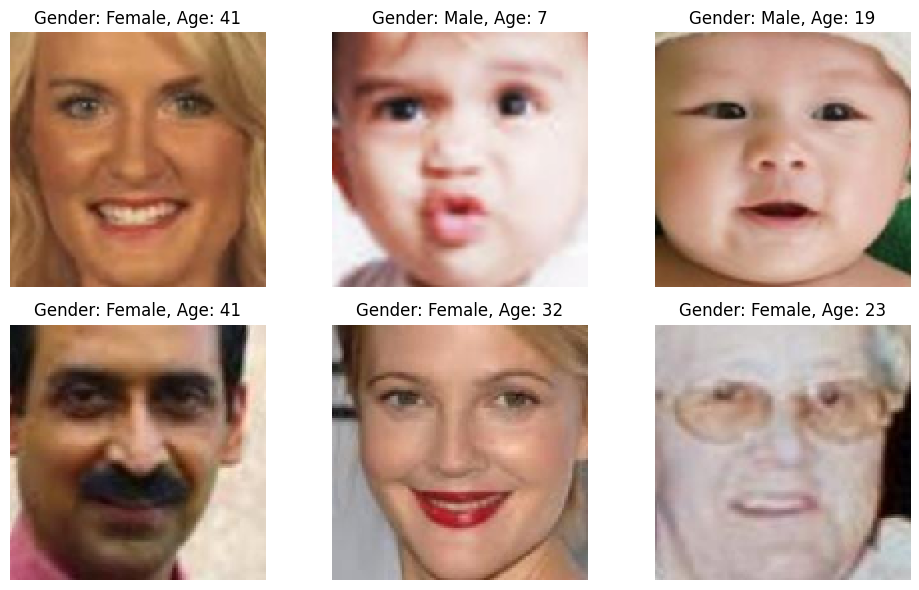

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    # Ensure image data is in the correct format for display (uint8)
    img_to_display = (X_test[i] * 255).astype('uint8')
    plt.imshow(img_to_display)

    # Get predictions for the current image
    # Need to reshape for single prediction
    single_image = np.expand_dims(X_test[i], axis=0)
    gender_predicts_single, age_predicts_single = model.predict(single_image)

    # Process predictions
    gender = 'Male' if gender_predicts_single > 0.5 else 'Female'
    age = int(age_predicts_single.flatten()[0])

    plt.title(f"Gender: {gender}, Age: {age}")
    plt.axis('off')

plt.tight_layout()
plt.show()

**trying the model on samples from mobile**

In [110]:
#preprocess the image
from tensorflow.keras.preprocessing import image
import numpy as np

In [112]:
#function to preprocess the image
def preprocess_img(img_path):
  img = image.load_img(img_path, target_size= (128,128))
  img_array = image.img_to_array(img)
  img_array = img_array / 255.0 #normalize
  img_array = np.expand_dims(img_array, axis = 0) #adds batch dimension
  return img_array

In [120]:
#making predictions
img_path1 = "/content/1754221957041.jpg"
img_path2 = "/content/1754221957051.jpg"

# Assuming you know the actual ages for these images
actual_age1 = 65  # Replace with the actual age for img_path1
actual_age2 = 70  # Replace with the actual age for img_path2


img_input1 = preprocess_img(img_path1)
img_input2 = preprocess_img(img_path2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


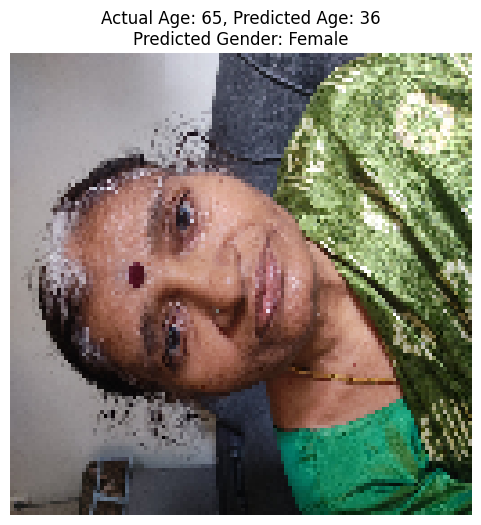

Actual Age for image 1: 65
Predicted Gender for image 1: Female
Predicted Age for image 1: 36


In [122]:
# Display the first image and its prediction
plt.figure(figsize=(6, 6))
img1 = image.load_img(img_path1, target_size=(128, 128))
plt.imshow(img1)
gender_pred1, age_pred1 = model.predict(img_input1)
gender1 = "Male" if gender_pred1[0][0] > 0.5 else "Female"
age1 = int(age_pred1[0][0])
plt.title(f"Actual Age: {actual_age1}, Predicted Age: {age1}\nPredicted Gender: {gender1}")
plt.xticks(rotation = 45)
plt.axis('off')
plt.show()

print(f"Actual Age for image 1: {actual_age1}")
print(f"Predicted Gender for image 1: {gender1}")
print(f"Predicted Age for image 1: {age1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


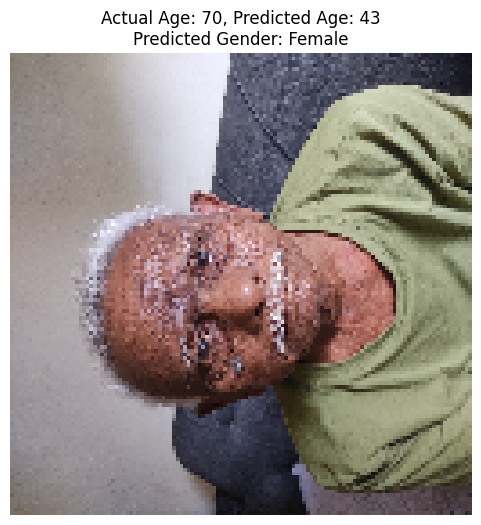

Actual Age for image 2: 70
Predicted Gender for image 2: Female
Predicted Age for image 2: 43


In [123]:
# Display the second image and its prediction
plt.figure(figsize=(6, 6))
img2 = image.load_img(img_path2, target_size=(128, 128))
plt.imshow(img2)
gender_pred2, age_pred2 = model.predict(img_input2)
gender2 = "Male" if gender_pred2[0][0] > 0.5 else "Female"
age2 = int(age_pred2[0][0])
plt.title(f"Actual Age: {actual_age2}, Predicted Age: {age2}\nPredicted Gender: {gender2}")
plt.xticks(rotation = 45)
plt.axis('off')
plt.show()

print(f"Actual Age for image 2: {actual_age2}")
print(f"Predicted Gender for image 2: {gender2}")
print(f"Predicted Age for image 2: {age2}")